# Video Enhancement By Transfer Learning

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [2]:
vid_dir = '/storage/VideoEnhancement/'
vid_name = 'input'
vid_path = vid_dir+vid_name+'.mp4'

In [3]:
name_output = 'vid-enh-try1'
name_ref = 'input-images'

# Video processing

Install ffmpeg using the indications in https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg
`
sudo add-apt-repository ppa:mc3man/trusty-media
sudo apt-get update  
sudo apt-get install ffmpeg  
sudo apt-get install frei0r-plugins
`

In [4]:
# # Uncomment the first time you run this notebook
# ! pip install moviepy
# ! pip install ffmpeg

In [5]:
from moviepy.editor import *

In [6]:
video = VideoFileClip(vid_path)

In [7]:
# #Uncomment when running for the first time this notebook in order to check that it works
# video.ipython_display()

In [8]:
fps = video.fps
fps

30.0

In [9]:
path_images = Path(vid_dir)/name_ref
path_images.mkdir(exist_ok=True)

Q: how can we accelerate this image writing process? It's currently the main bottleneck

In [14]:
# # Uncomment this when you run for the first time
# video.write_images_sequence(str(path_images)+'/frame%03d.png')

#  Fastai lesson 7 notebook

In [15]:
path = Path(vid_dir)
path_hr = path/'input-images' ## 512x288
path_lr = path/'lowres-72' ## 128x72
path_mr = path/'medres-144'## 256x144

In [16]:
il = ImageList.from_folder(path_hr)
il

ImageList (1636 items)
Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512)
Path: /storage/VideoEnhancement/input-images

In [17]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [19]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 72), (path_mr, 144)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [20]:
bs,size=16,256
arch = models.resnet34
src = ImageImageList.from_folder(path_mr).split_none()

In [21]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [22]:
data = get_data(bs,size)

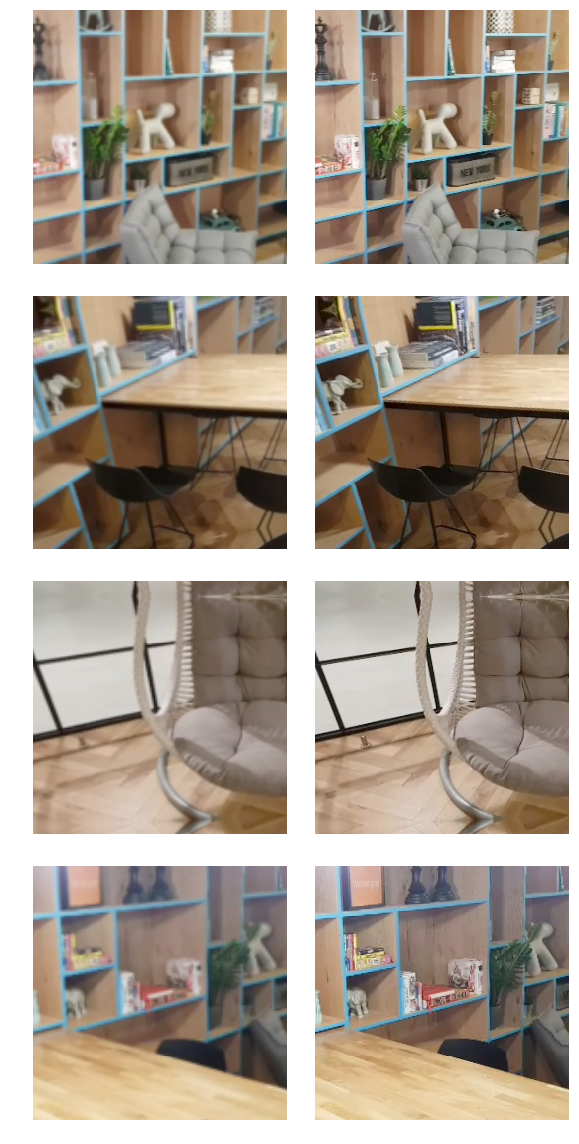

In [23]:
data.show_batch(ds_type=DatasetType.Train, rows=4)

## Feature loss

In [24]:
t = data.train_ds[0][1].data
t = torch.stack([t,t])

In [25]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [26]:
gram_matrix(t)

tensor([[[0.0845, 0.0733, 0.0634],
         [0.0733, 0.0656, 0.0579],
         [0.0634, 0.0579, 0.0521]],

        [[0.0845, 0.0733, 0.0634],
         [0.0733, 0.0656, 0.0579],
         [0.0634, 0.0579, 0.0521]]])

In [27]:
base_loss = F.l1_loss

In [28]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [29]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [30]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [31]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Training

## Define the model and load the pets one

In this section, we load the pet model obtained at the end of the [superres-notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres.ipynb). Please refer to [fastai course v3 lesson 7](https://forums.fast.ai/t/lesson-7-official-resources/32553) for more details.

In [32]:
wd = 1e-4
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [33]:
path_regular_superres = Path('/storage/oxford-iiit-pet/small-96/models')
path_regular_superres.ls()

[PosixPath('/storage/oxford-iiit-pet/small-96/models/2a.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/2b.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/1a.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/1b.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/tmp.pth')]

In [35]:
learn.load((path_regular_superres/'2b').absolute());

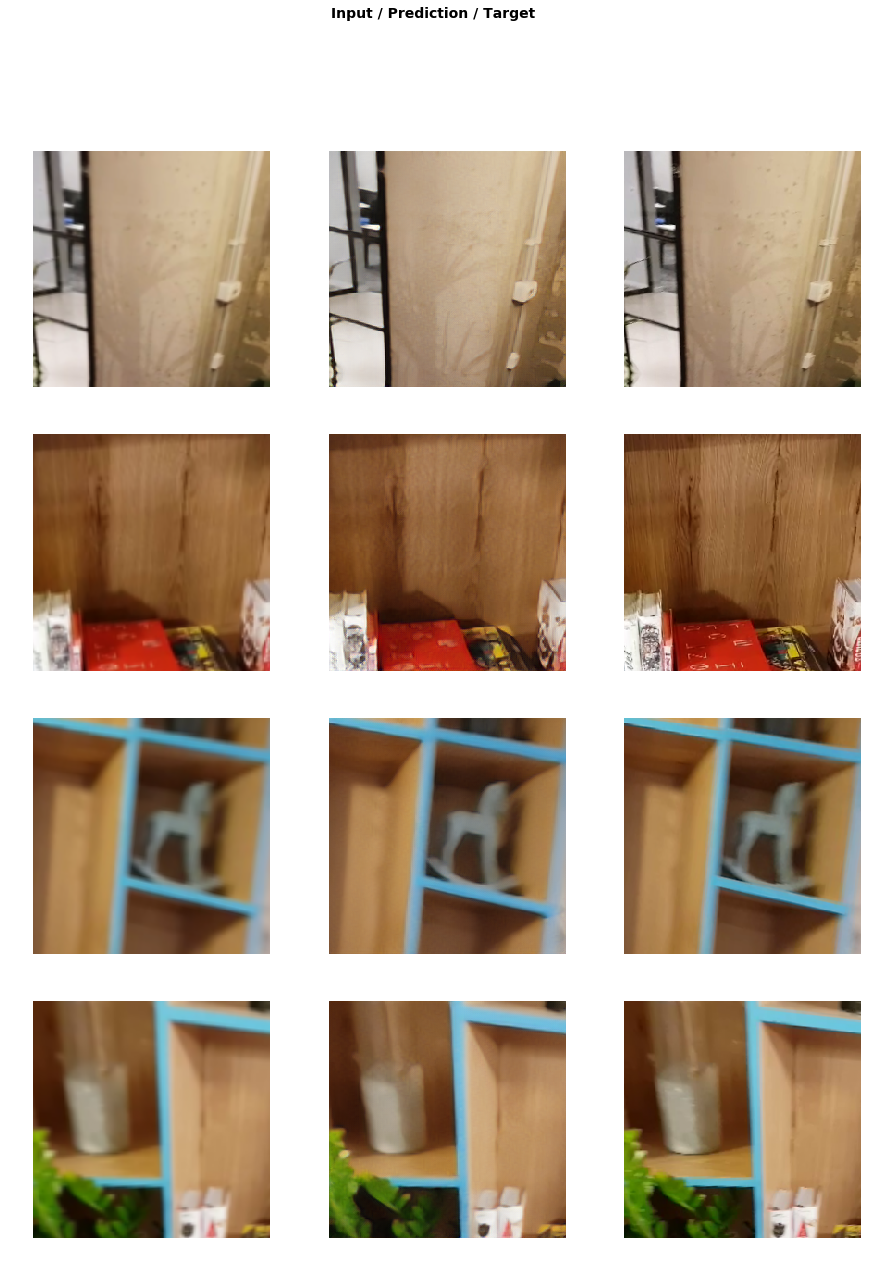

In [36]:
learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [37]:
model_name_pets = 'enhance-pets'
learn.save(model_name_pets)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


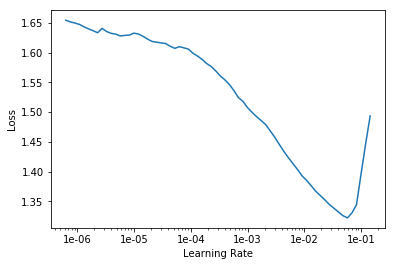

In [38]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [39]:
lr = 1e-3

## Fast Training

In [40]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-6,lr))

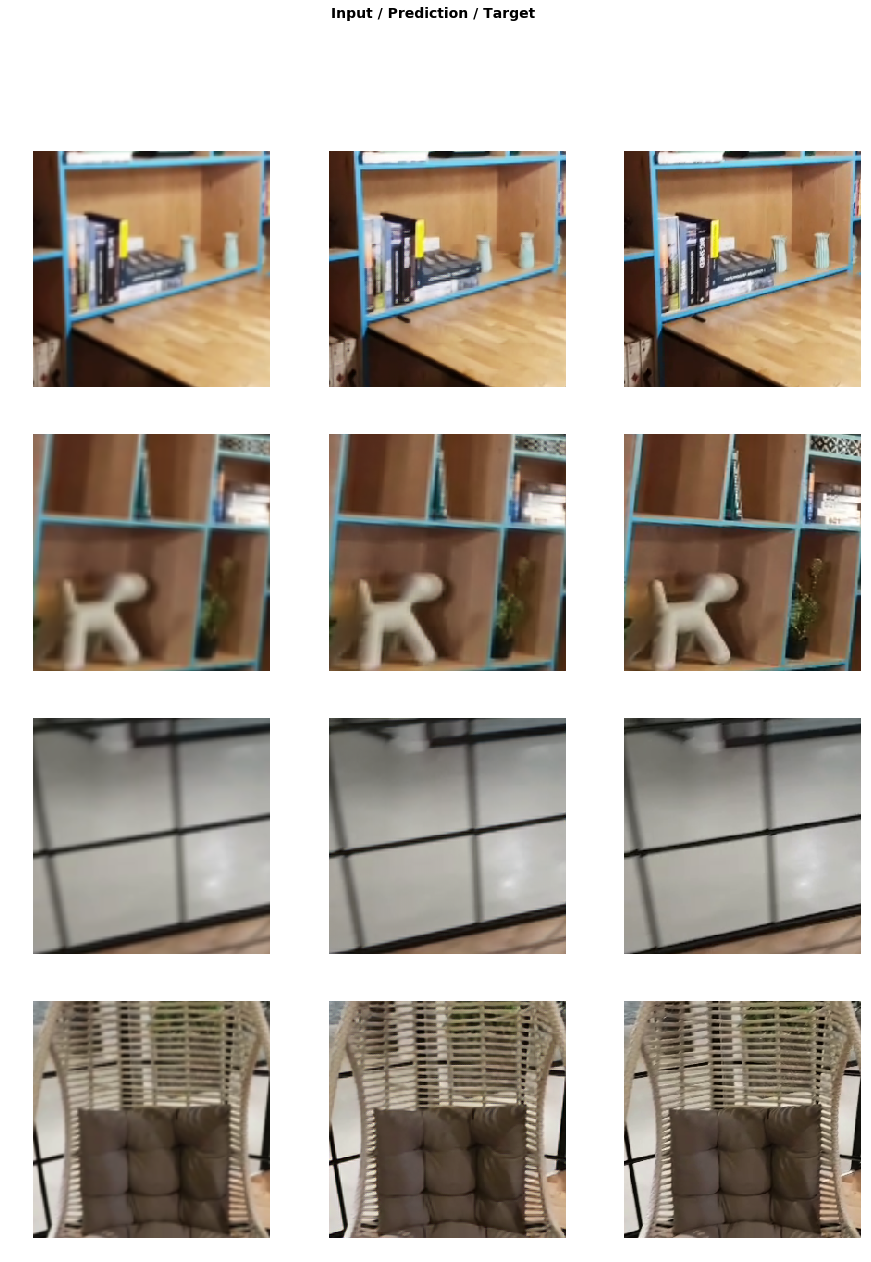

In [41]:
model_name = 'enhance-video' 
learn.save(model_name)
learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [42]:
# learn.fit_one_cycle(10, slice(1e-6,lr))
# learn.save('superres-overfit-1b')
# learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [43]:
# learn.fit_one_cycle(10, slice(1e-6,lr/100))
# learn.save('superres-overfit-1c')
# learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

# Apply the network on one image and compare

In [44]:
idx_img = random.randint(0, len(il))
idx_img

1613

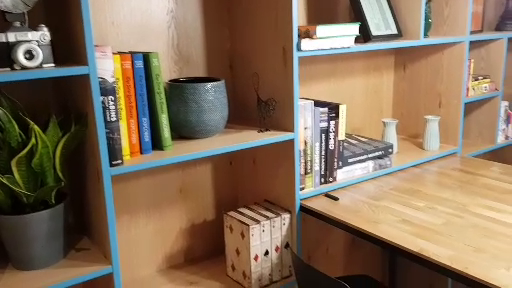

In [45]:
test_img = open_image(il.items[idx_img])
test_img

In [46]:
test_img.shape

torch.Size([3, 288, 512])

In [47]:
def round_up_to_even(f): 
    return math.ceil(f / 2.) * 2

rounded_up_size = round_up_to_even(test_img.shape[1]), round_up_to_even(test_img.shape[2])
new_size = rounded_up_size[0], rounded_up_size[1]
new_size

(288, 512)

In [48]:
path_test = path_images
data_test = (ImageImageList.from_folder(path_test).no_split()
          .label_from_func(lambda x: path_test/x.name)
          .transform(get_transforms(do_flip=False), size=new_size, tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))
data_test.c = 3

In [49]:
learn = unet_learner(data_test, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [50]:
def enhance_one(test_img):
    return learn.predict(test_img)[0]

In [51]:
folder = 'medres-144'
learn.load(path/f'{folder}/models/{model_name_pets}');
test_out_enh_pets = enhance_one(test_img)

learn.load(path/f'{folder}/models/{model_name}');
test_out_enh_vid = enhance_one(test_img)


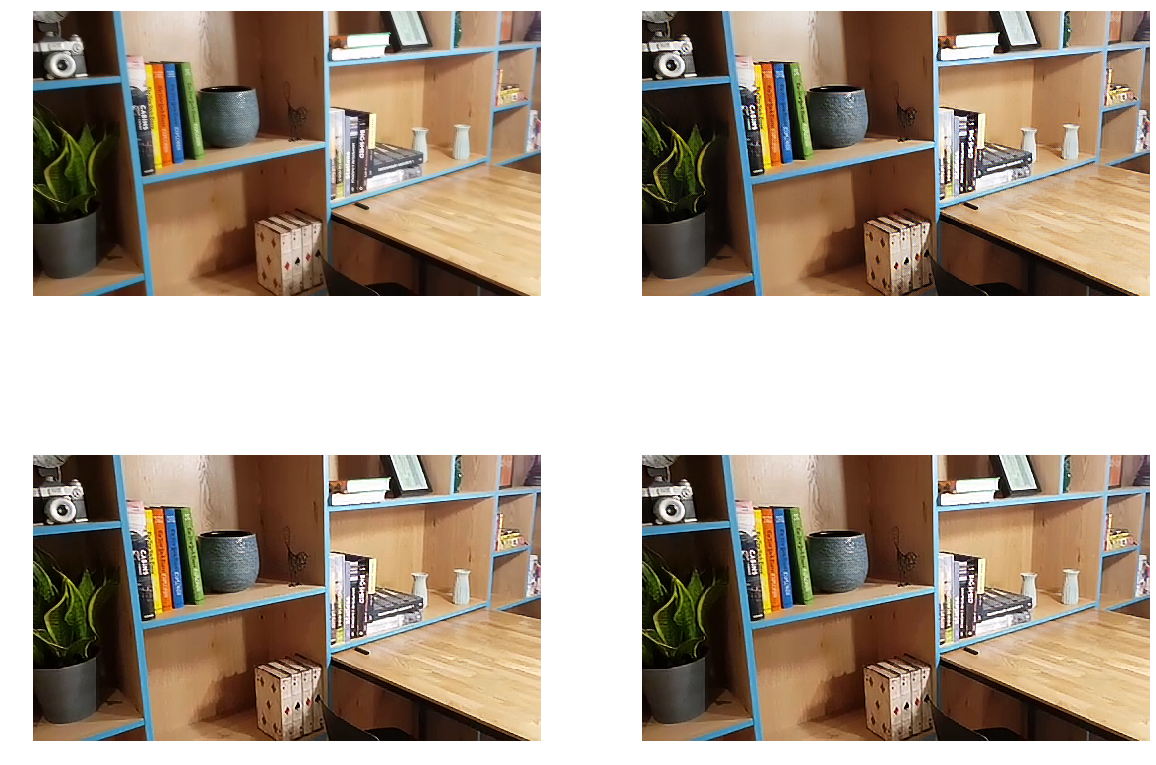

In [52]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
test_img.show(ax[0,0])
test_out_enh_pets.show(ax[0,1])
test_out_enh_vid.show(ax[1,0])
test_out_enh_vid.show(ax[1,1])

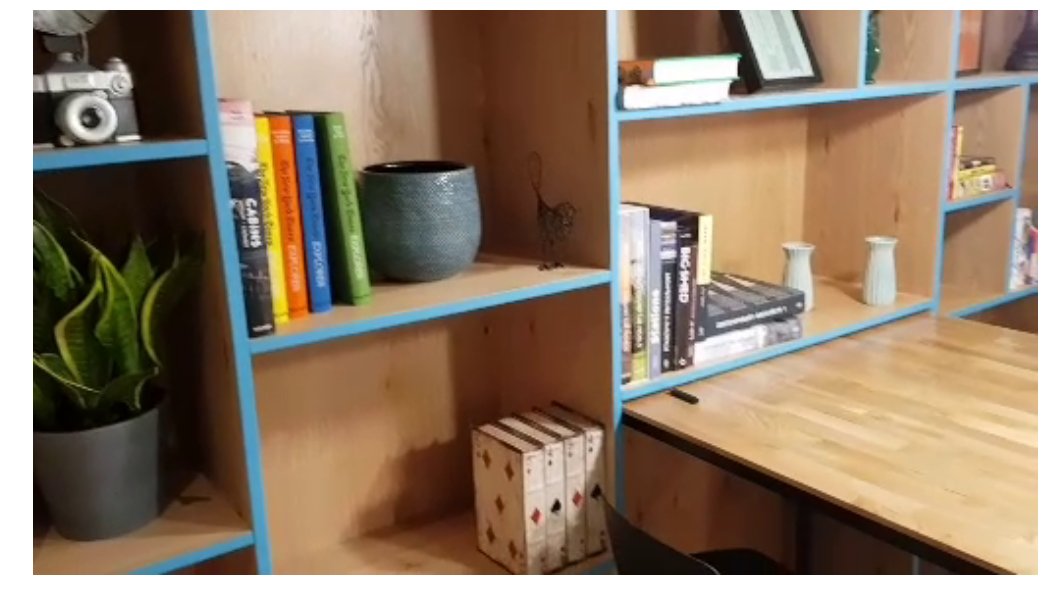

In [53]:
show_image(test_img, figsize=(18,15), interpolation='bilinear');

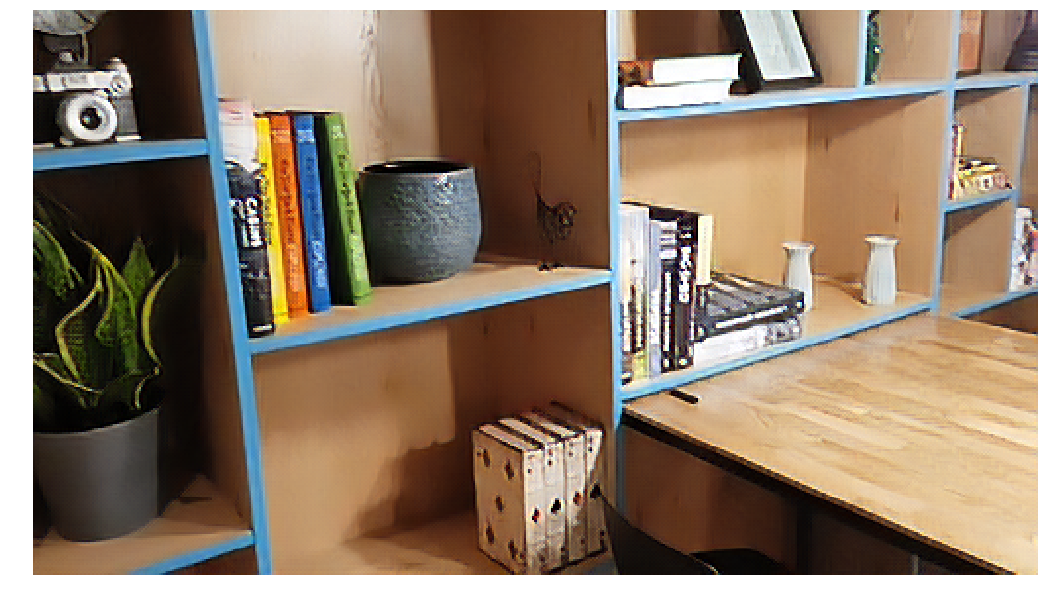

In [54]:
test_out_enh_pets.show(figsize=(18,15))

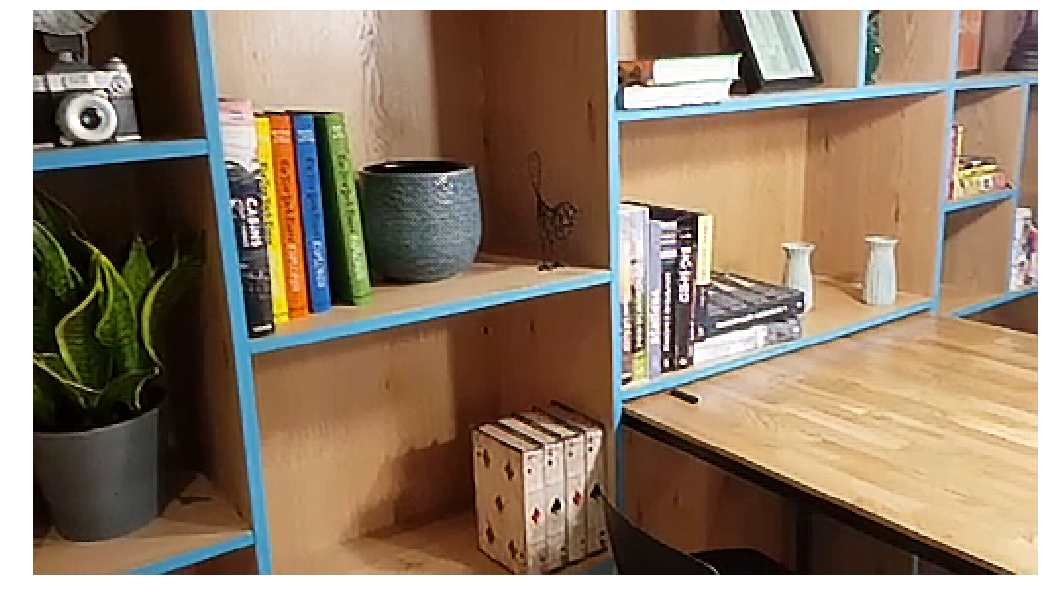

In [55]:
test_out_enh_vid.show(figsize=(18,15))

# Apply model on all the images

In [56]:
# torch.cuda.device("cpu")
# learn.num_workers = 1

In [57]:
learn.load(path/f'{folder}/models/{model_name}');
p=Path('vid-enh-test')

In [58]:
# preds, y = learn.get_preds(DatasetType.Train)

In [59]:
def apply_one(fn, i, path_out):
    dest = path_out/fn.relative_to(path_images)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = open_image(fn)
    enh_img = enhance_one(img)
    enh_img.save(dest)

In [60]:
apply_one(il.items[5],i=24, path_out=p)

In [ ]:
from tqdm import tqdm
p=Path(name_output)
p.mkdir(exist_ok=True)
for fn in tqdm(il.items):
    apply_one(fn,0,p)

 69%|██████▊   | 1122/1636 [02:29<01:06,  7.77it/s]

In [ ]:
# p=Path('superres-mstn1')
# if not p.exists(): 
#     parallel(partial(apply_one, path_out=p), il.items)

In [ ]:
# # create smaller image sets the first time this nb is run
# sets = [('path_lr', 72), (path_mr, 144)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

# Generate videos and compare them

In [ ]:
def exec_cmd(cmd):
    print(f'cmd = {cmd}')
    log = subprocess.check_output(cmd, shell=True)
    return log

In [ ]:
def create_output_video(folder_name, fps=video.fps):
    cmd = f'ffmpeg -framerate {str(fps)} -i {folder_name}/frame%03d.png -c:v libx264 {folder_name}.mp4'
    return exec_cmd(cmd)

In [ ]:
# ! ffmpeg -framerate 30 -i input-images/frame%03d.png -c:v libx264 input-images.mp4

In [ ]:
create_output_video(name_ref)
create_output_video(name_output)

In [ ]:
def merge_2_vid(name_vid1, name_vid2, name_comparison):
    cmd = f'ffmpeg -i {name_vid1}.mp4 -i {name_vid2}.mp4 -filter_complex vstack=inputs=2 {name_comparison}.mp4'
    print(f'cmd = {cmd}')
    log = subprocess.check_output(cmd, shell=True)
    return log

In [ ]:
# ! ffmpeg -i vid-reg -i vid-superres-mstn2 -filter_complex vstack=inputs=2 vid-comparison.mp4

In [ ]:
name_comparison = f'{name_output}_vs_{name_ref}'
merge_2_vid(name_output,name_ref, name_comparison)

In [ ]:
VideoFileClip(name_comparison+'.mp4').ipython_display()